# Advanced Lane Lines
Everything starts with some helper emthods.

In [1]:
import glob
import matplotlib.image as mpimg

def load_images(path_pattern):
    """
    Loads the images from the path.
    :param path_pattern: Path to the images to be loaded.
    :return: List of tuples (filename, image).
    """
    images = list(map(lambda filename: (filename, mpimg.imread(filename)), glob.glob(path_pattern)))
    return images

In [2]:
import matplotlib.pyplot as plt

def plot_images_side_by_side(left_img, left_title, right_img, right_title):
    """
    Display the images `leftImg` and `rightImg` side by side with image titles.
    :param left_img: Image to be plotted on the left side.
    :param left_title: Title to be plotted on the left side.
    :param right_img: Image to be plotted on the right side.
    :param right_title: Title to be plotted on the right side.
    """
    fig, axes = plt.subplots(ncols=2, figsize=(20,10))
    fig.tight_layout()
    axes[0].imshow(left_img, cmap='gray')
    axes[0].set_title(left_title, fontsize=20)
    axes[1].imshow(right_img, cmap='gray')
    axes[1].set_title(right_title, fontsize=20)
    return

## Camera Calibration
I have created a class Camera for both the camera calibration and the distortion correction. The `calibration()` function loads the calibration images at the given `path_pattern` (./camera_cal/calibration*.jpg) and uses the `cv2.findChessboardCorners()` and the `cv2.calibrateCamera()` function to set the camara calibration values.

In [3]:
import numpy as np
import cv2
%matplotlib inline

class Camera:
    """
    `Camera` class holding the characteristics of the camera in use.
    """
    def __init__(self, image_width=1280, image_height=720):
        # Distortion coefficients mtx and dist
        self.mtx = None
        self.dist = None
        # Calibration images
        self.calibration_images = []
        # Image size
        self.image_size = (image_width, image_height)
    
    def calibrate(self, path_pattern='./camera_cal/calibration*.jpg', num_x=9, num_y=6):
        """
        Function for camera calibration. It Loads the images at the given `path`
        and uses the `cv2.findChessboardCorners()` and the `cv2.calibrateCamera()`
        function to set the camara calibration values.
        :param path_pattern: Path where to search for calibration images.
        :param num_x: Number of intersections in x direction.
        :param num_y: Number of intersections in y direction.
        """
        # Arrays to store object points and image points from all the images
        objpoints = [] # 3D points in real world space
        imgpoints = [] # 2D points in image plane
        
        # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ...., (8,5,0)
        objp = np.zeros((num_y*num_x,3), np.float32)
        objp[:,:2] = np.mgrid[0:num_x,0:num_y].T.reshape(-1,2) # x, y coordinates
        
        # Load calibration images
        self.calibration_images = [i[1] for i in load_images(path_pattern)]
        
        # For every image
        for img in self.calibration_images:
            # Convert image to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            
            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (num_x,num_y), None)
            
            # If corners are found, add object points, image points
            if ret == True:
                imgpoints.append(corners)
                objpoints.append(objp)
        
        _, self.mtx, self.dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, self.image_size, None, None)
        return
    
    def undistort_image(self, img):
        """
        Function for distortion correction. Uses the cv2.undistort function to
        calculate an undistorted image using the camara calibration values.
        :param img: Input image to be undistorted.
        :return: Undistorted image.
        """
        dst = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        return dst

In [4]:
# Create camera object and calibrate the camera
camera = Camera()
camera.calibrate()

In [5]:
print('mtx =')
print(camera.mtx)
print('dist =')
print(camera.dist)

mtx =
[[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
dist =
[[ -2.41017956e-01  -5.30721173e-02  -1.15810355e-03  -1.28318856e-04
    2.67125290e-02]]


## Distortion Correction
As seen before, the distortion correction is part of the `Camera` class. Here is an example usage of the `undistort_image()` function.

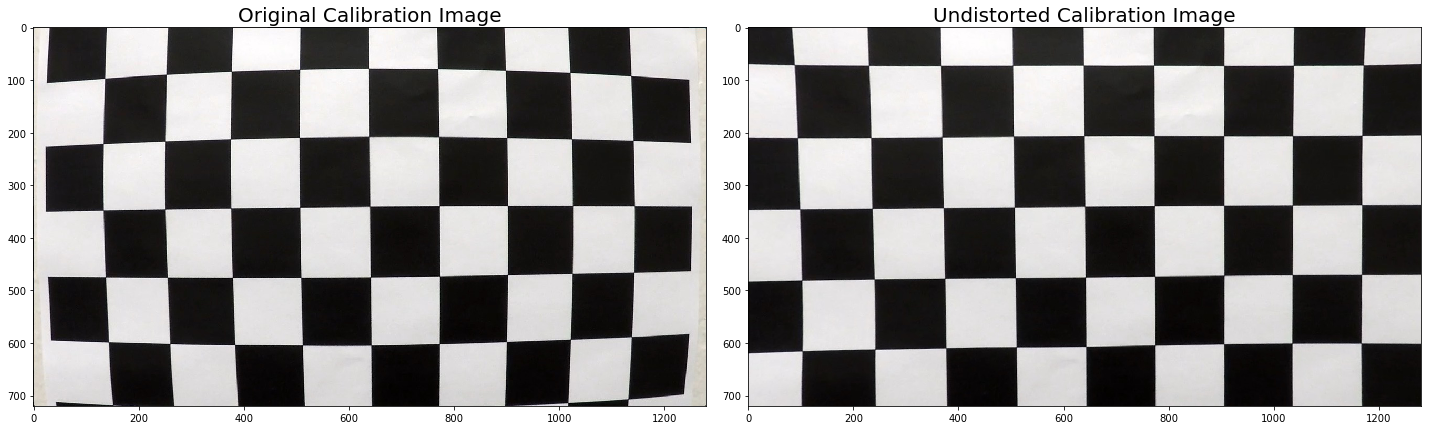

In [6]:
# Read in a calibration image
img = mpimg.imread('camera_cal/calibration1.jpg')
undistorted = camera.undistort_image(img)

plot_images_side_by_side(
    img, 'Original Calibration Image',
    undistorted, 'Undistorted Calibration Image'
)

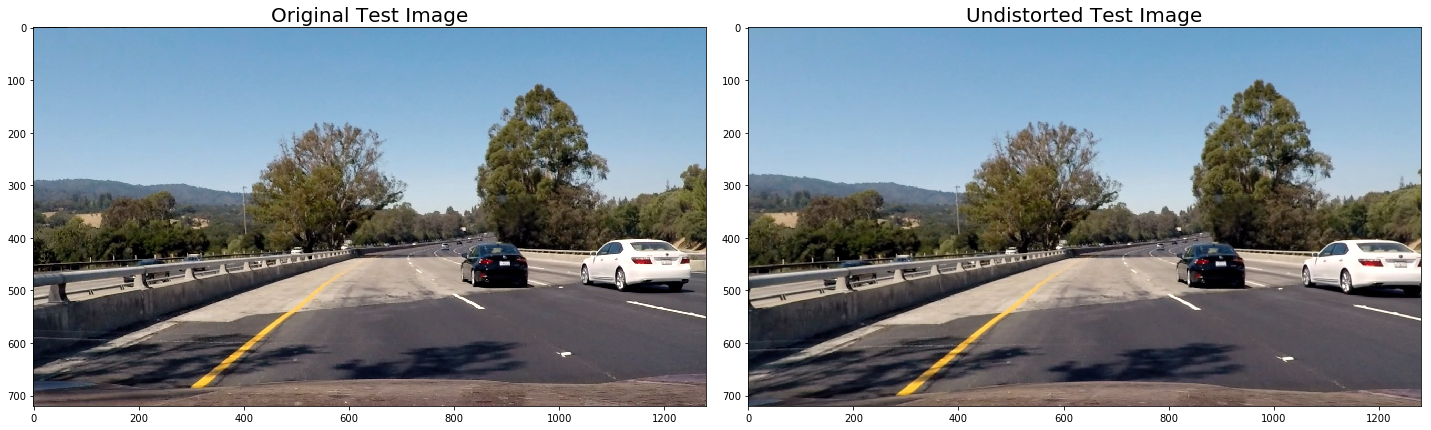

In [7]:
# Read in a test image
img = mpimg.imread('test_images/test4.jpg')
undistorted = camera.undistort_image(img)

plot_images_side_by_side(
    img, 'Original Test Image',
    undistorted, 'Undistorted Test Image'
)

## Color and Gradient Threshold

In [8]:
class ImageThresher:
    def mag_thresh(self, img, sobel_kernel=3, mag_thresh=(0, 255)):
        """
        Returns an array of the same size as the input image of 'ones' where gradients
        were in the threshold range, and 'zeros' everywhere else.
        :param img: Input image in RGB format.
        :param sobel_kernel: Size of the Sobel kernel (must be odd number >= 3).
        :param mag_thresh: Threshold (0 to 255) for gradient magnitude.
        """
        # Convert image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Take the gradient in x and y separately
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Calculate the magnitude of the gradient
        mag = np.sqrt(sobelx * sobelx + sobely * sobely)
        # Scale to 8-bit (0-255)
        scaled_mag = np.uint8(255*mag/np.max(mag))
        # Apply threshold
        binary_output = np.zeros_like(scaled_mag)
        binary_output[(scaled_mag >= mag_thresh[0]) & (scaled_mag <= mag_thresh[1])] = 1
        # Return binary output image
        return binary_output
    
    def dir_thresh(self, img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
        """
        Returns an array of the same size as the input image of 'ones' where gradient
        directions were in the threshold range, and 'zeros' everywhere else.
        :param img: Input image in RGB format.
        :param sobel_kernel: Size of the Sobel kernel (must be odd number >= 3).
        :param dir_thresh: Threshold (0 to pi/2) for gradient directions.
        """
        # Convert image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Take the gradient in x and y separately
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Use np.arctan2(abs_sobely, abs_sobelx) to calculate direction of the gradient
        abs_sobelx = np.absolute(sobelx)
        abs_sobely = np.absolute(sobely)
        absgraddir = np.arctan2(abs_sobely, abs_sobelx)
        # Apply threshold
        binary_output = np.zeros_like(absgraddir)
        binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1
        # Return binary output image
        return binary_output
    
    def color_thresh(self, img, r_thresh=(0, 255), s_thresh=(0, 255)):
        """
        Returns an array of the same size as the input image of 'ones' where pixel values
        were in the threshold range, and 'zeros' everywhere else.
        :param img: Input image in RGB format.
        :param r_thresh: Threshold (0 to 255) for the R channel.
        :param s_thresh: Threshold (0 to 255) for the S channel.
        """
        # Apply threshold to the R channel
        r_channel = img[:,:,0]
        r_binary = np.zeros_like(r_channel)
        # Create a mask of 1's where pixel value is within the given threshold
        r_binary[(r_channel > r_thresh[0]) & (r_channel <= r_thresh[1])] = 1
        # Convert to HLS color space
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        # Apply threshold to the S channel
        s_channel = hls[:,:,2]
        s_binary = np.zeros_like(s_channel)
        # Create a mask of 1's where pixel value is within the given threshold
        s_binary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
        # Combine two channels
        combined = np.zeros_like(r_binary)
        combined[(r_binary == 1) | (s_binary == 1)] = 1
        # Return binary output image
        return combined
    
    def combined_thresh(self, img):
        """
        Returns an array of the same size as the input image and combines the `mag_thresh()`
        function, the `dir_thresh()` function, and the `color_thresh()` function.
        :param img: Input image in RGB format.
        """
        # Threshold gradient
        mag_binary = self.mag_thresh(img, sobel_kernel=9, mag_thresh=(50, 255))
        dir_binary = self.dir_thresh(img, sobel_kernel=15, dir_thresh=(0.7, 1.3))
        # Combine the two binary images
        grad_binary = np.zeros_like(img[:,:,0])
        grad_binary[((mag_binary == 1) & (dir_binary == 1))] = 1
        # Threshold color
        color_binary = self.color_thresh(img, r_thresh=(220, 255), s_thresh=(150, 255))
        # Combine gradient and color binary images
        combo_binary = np.zeros_like(img[:,:,0])
        combo_binary[(grad_binary == 1) | (color_binary == 1)] = 255
        # Return combined binary output image
        return combo_binary

# Create an instance of the class
thresher = ImageThresher()

## Perspective Transform
For the perspective transform I implemented another class called `ImageWarper`. Based on an example image I defined the transform points for calculating the perspective transform matrix `self.M` as well as the inverse perspective transform matrix `self.M_inv`. An image can be warped and unwarped using the functions `warp_image(img)` and `unwarp_image(img)`.

In [9]:
class ImageWarper:
    def __init__(self, image_size, offset=200):
        """
        Initializes an `ImageWarper` object.
        :param image_size: The size of the images.
        :param offset: The offset that is used on the left and right side.
        """
        self.y_top = 455
        self.y_bottom = 690
        self.x_bottom_l = 240
        self.x_top_l = 585
        self.x_top_r = 700
        self.x_bottom_r = 1085
        self.width, self.height = image_size
        
        self.src = np.float32([ 
            [self.x_bottom_l, self.y_bottom],
            [self.x_top_l, self.y_top],
            [self.x_top_r, self.y_top],
            [self.x_bottom_r, self.y_bottom]
        ])
        
        # Using an offset on the left and right side allows the lanes to curve
        self.dst = np.float32([
            [offset, self.height],
            [offset, 0],
            [self.width-offset, 0], 
            [self.width-offset, self.height]
        ])
        
        # Calculate M, the transform matrix
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)
        self.M_inv = cv2.getPerspectiveTransform(self.dst, self.src)
    
    def warp_image(self, img):
        """
        Warps an image usung the perspective transform matrix.
        :param img: Input image.
        :return: The warped image.
        """
        return cv2.warpPerspective(img, self.M, (self.width, self.height))
    
    def unwarp_image(self, img):
        """
        Warps an image usung the inverse perspective transform matrix.
        :param img: Input image.
        :return: The warped image.
        """
        return cv2.warpPerspective(img, self.M_inv, (self.width, self.height))
    
    def draw_polygon_on_image(self, img, mode='src', color=[255, 0, 0], thickness=2):
        """
        Draws a polygon with the transform points onto the image (`img`).
        :param img: Input image.
        :param mode: Mode ('src', 'dst') of polygon drawing.
        :param color: Color of the drawn polygon.
        :param thickness: Thickness of the drawn polygon.
        :return: Image with transform polygon on it.
        """
        copy = img.copy()
        points = self.src if mode=='src' else self.dst
        cv2.line(copy, (points[0][0], points[0][1]), (points[1][0], points[1][1]), color, thickness)
        cv2.line(copy, (points[1][0], points[1][1]), (points[2][0], points[2][1]), color, thickness)
        cv2.line(copy, (points[2][0], points[2][1]), (points[3][0], points[3][1]), color, thickness)
        cv2.line(copy, (points[3][0], points[3][1]), (points[0][0], points[0][1]), color, thickness)
        return copy

# Create an instance of the class
warper = ImageWarper(image_size=camera.image_size)

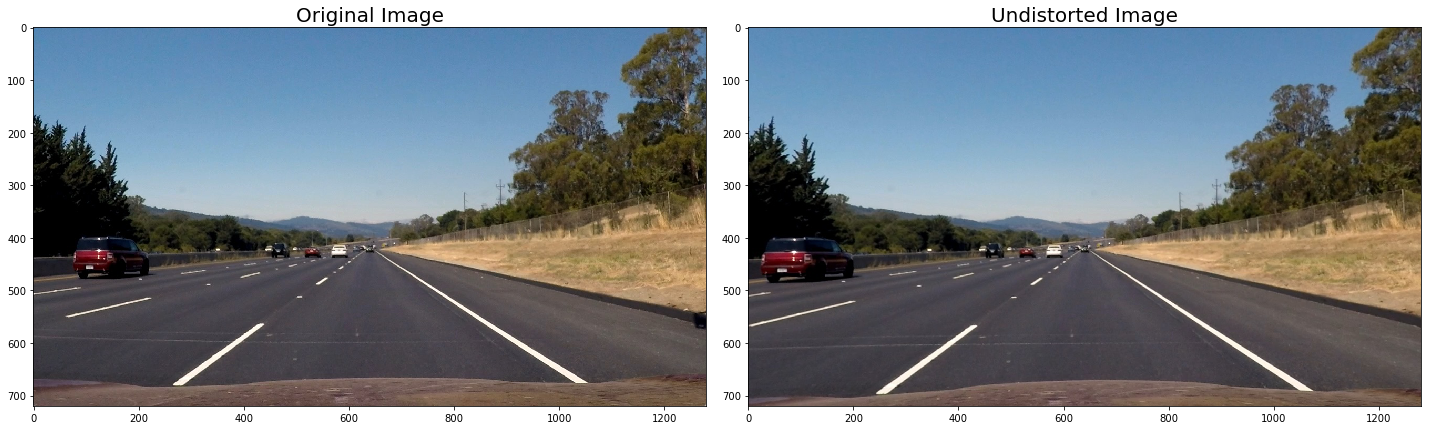

In [10]:
# Load test images
test_images = load_images('./test_images/st*.jpg')

index = 0
original = test_images[index][1]
undistorted = camera.undistort_image(original)

plot_images_side_by_side(
    original, 'Original Image',
    undistorted, 'Undistorted Image'
)

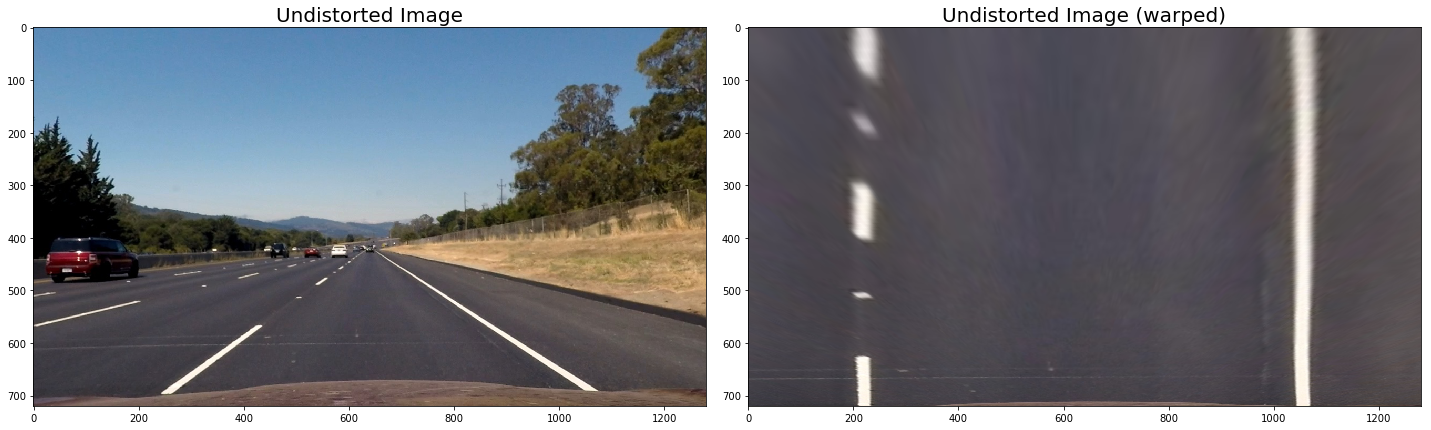

In [11]:
# Warp image to a top-down-view
warped = warper.warp_image(undistorted)

plot_images_side_by_side(
    undistorted, 'Undistorted Image',
    warped, 'Undistorted Image (warped)'
)

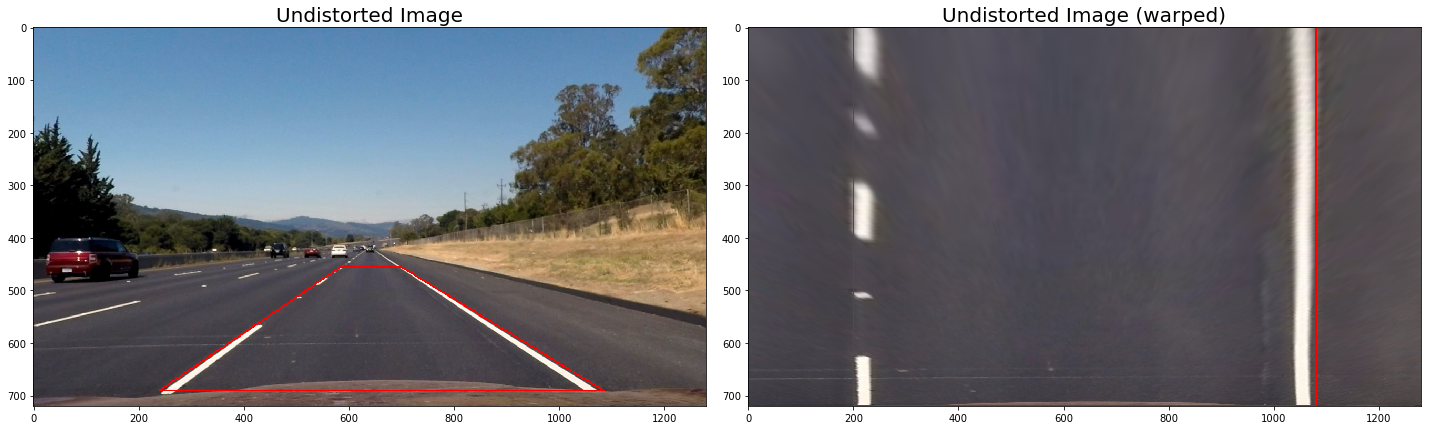

In [12]:
# Draw warp polygon on both of the images
undistorted_poly = warper.draw_polygon_on_image(undistorted, mode='src')
warped_poly = warper.draw_polygon_on_image(warped, mode='dst')

plot_images_side_by_side(
    undistorted_poly, 'Undistorted Image',
    warped_poly, 'Undistorted Image (warped)'
)

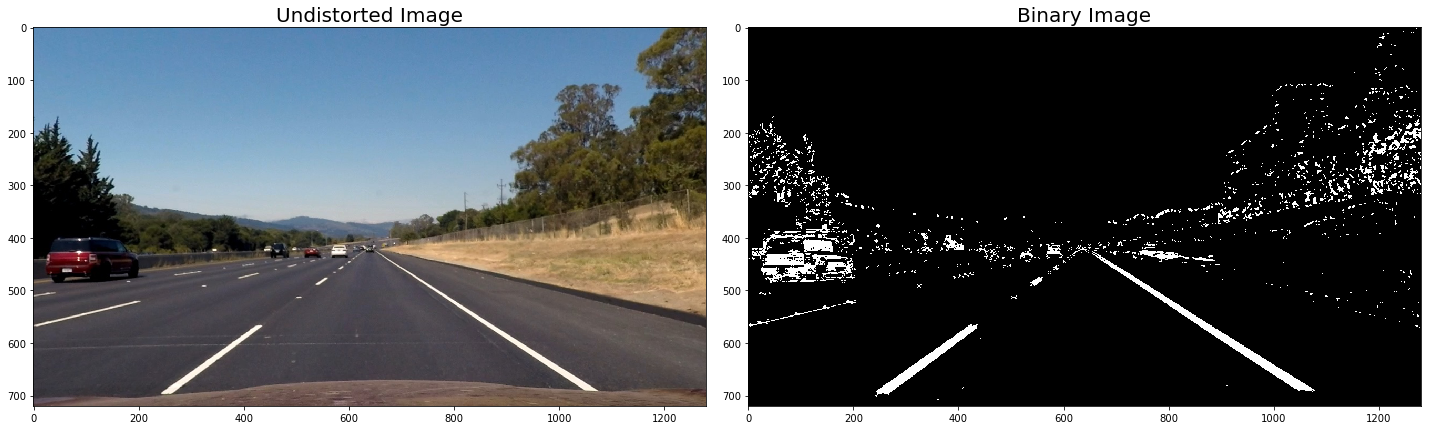

In [13]:
# Adapt color and gradient threshold
binary = thresher.combined_thresh(undistorted)

plot_images_side_by_side(
    undistorted, 'Undistorted Image',
    binary, 'Binary Image'
)

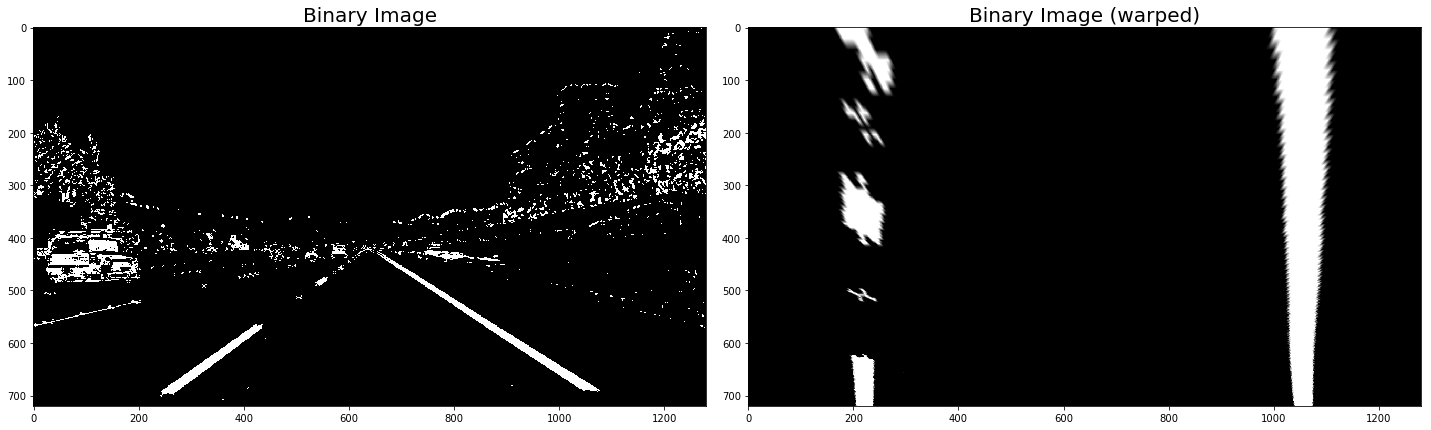

In [14]:
# Warp thresholded image to a top-down-view
binary_warped = warper.warp_image(binary)

plot_images_side_by_side(
    binary, 'Binary Image',
    binary_warped, 'Binary Image (warped)'
)

## Detect Lane Lines

In [15]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def find_lane_lines(binary_warped, nwindows=9, margin=100, minpix=50):
    """
    Find the polynomial representation of the lane lines.
    :param binary_warped: Binary image warped to a top-down-view.
    :param nwindows: The number of sliding windows.
    :param margin: The width of the windows +/- margin.
    :param minpix: The minimum number of pixels found to recenter window.
    :return: Lots of calculation information :)
    """
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img, (win_xright_low,win_y_low), (win_xright_high,win_y_high), (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each (in pixels)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit a second order polynomial to each (in meters)
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return (left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)

def find_and_visualize_lane_lines(binary_warped, plt):
    """
    Visualize the windows and fitted lane lines.
    :param binary_warped: Binary image warped to a top-down-view.
    :param plt: The plot object.
    :return: Lots of calculation information :)
    """
    # Find lane lines
    left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = find_lane_lines(binary_warped)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, num=binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    if plt is not None:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
        # Plot values
        fig, axes = plt.subplots(ncols=2, figsize=(20,10))
        fig.tight_layout()
        axes[0].imshow(binary_warped, cmap='gray')
        axes[0].set_title('Binary Image (warped)', fontsize=20)
        axes[1].imshow(out_img)
        axes[1].plot(left_fitx, ploty, color='yellow')
        axes[1].plot(right_fitx, ploty, color='yellow')
        axes[1].set_title('Binary Image (warped) with Lane Lines identified', fontsize=20)
    
    return (left_fit, right_fit, left_fit_m, right_fit_m, left_fitx, right_fitx)

Give it a try:

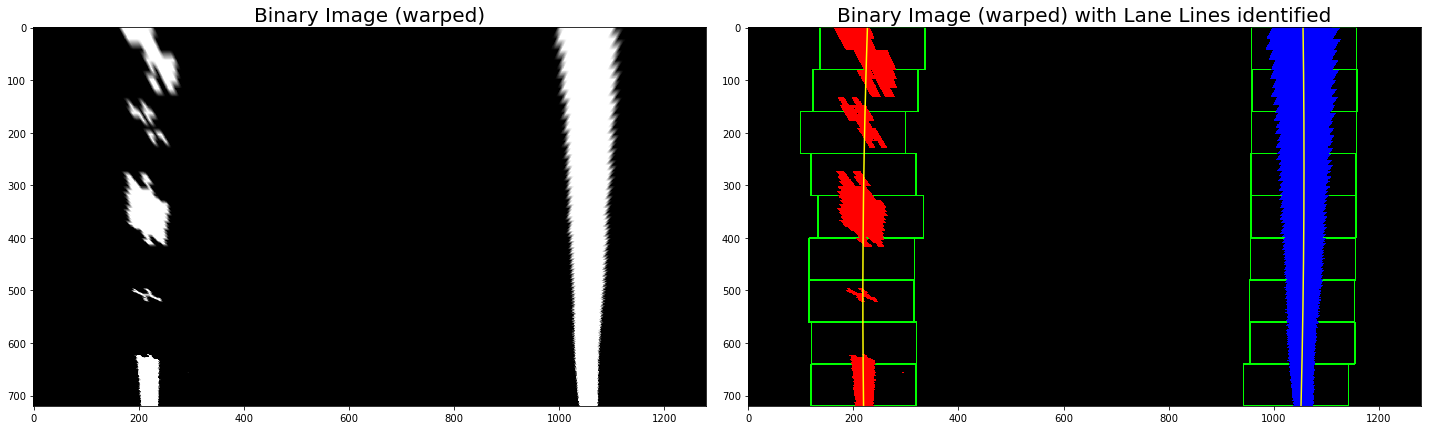

In [16]:
left_fit, right_fit, left_fit_m, right_fit_m, left_fitx, right_fitx = find_and_visualize_lane_lines(binary_warped, plt)

## Determine the Lane Curvature and the Vehicle Position

In [17]:
def calculate_lane_curvature_and_vehicle_position(binary_warped, left_fit_m, right_fit_m):
    # Calculate the radii of curvature
    y_eval = 719.0
    left_curverad = ((1 + (2*left_fit_m[0]*y_eval*ym_per_pix + left_fit_m[1])**2)**1.5) / np.absolute(2*left_fit_m[0])
    right_curverad = ((1 + (2*right_fit_m[0]*y_eval*ym_per_pix + right_fit_m[1])**2)**1.5) / np.absolute(2*right_fit_m[0])
    # Now the radius of curvature is in meters
    # Example values: 632.1 m    626.2 m
    
    # Calculate vehicle center
    xMax = binary_warped.shape[1]*xm_per_pix
    yMax = binary_warped.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)
    
    return (left_curverad, right_curverad, message)

def draw_info_on_image(img, left_curverad, right_curverad, message):
    copy = img.copy()
    
    # Draw info
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1
    fontColor = (255, 255, 255)
    cv2.putText(copy, 'Left curvature: {:.0f} m'.format(left_curverad), (50,50), font, fontScale, fontColor, 2)
    cv2.putText(copy, 'Right curvature: {:.0f} m'.format(right_curverad), (50,100), font, fontScale, fontColor, 2)
    cv2.putText(copy, 'Vehicle is {} of center'.format(message), (50,150), font, fontScale, fontColor, 2)
    return copy

Give it a try:

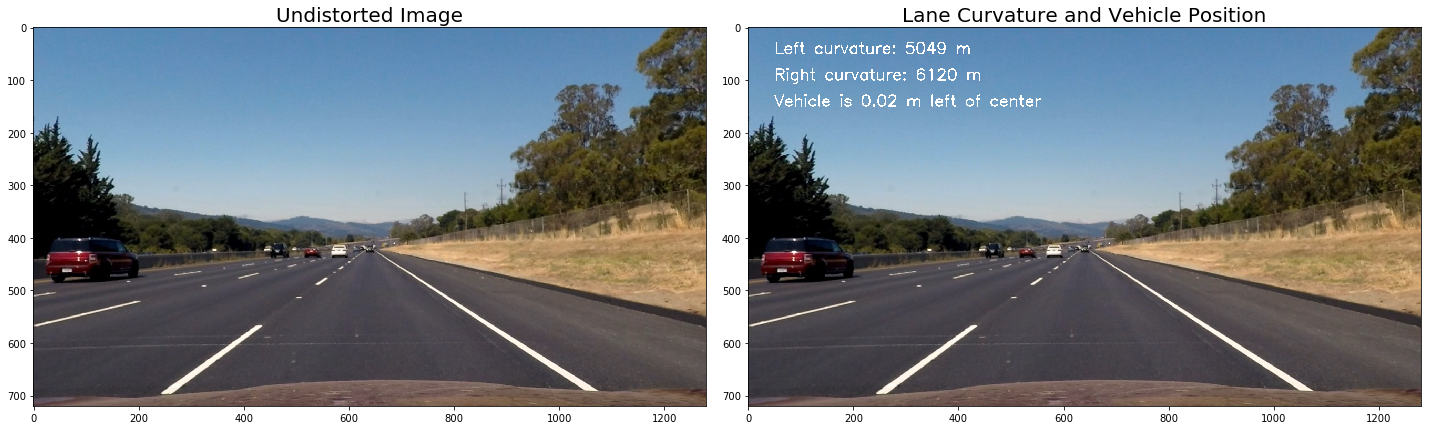

In [18]:
left_curverad, right_curverad, message = calculate_lane_curvature_and_vehicle_position(binary_warped, left_fit_m, right_fit_m)

result = draw_info_on_image(undistorted, left_curverad, right_curverad, message)

plot_images_side_by_side(
    undistorted, 'Undistorted Image',
    result, 'Lane Curvature and Vehicle Position'
)

## Draw the detected Lane Lines back onto the image

In [19]:
def draw_lane_lines_on_image(undist, warped, left_fitx, right_fitx):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, warped.shape[0]-1, num=warped.shape[0])
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # Warp blank image back to original image space
    newwarp = warper.unwarp_image(color_warp)
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

Give it a try:

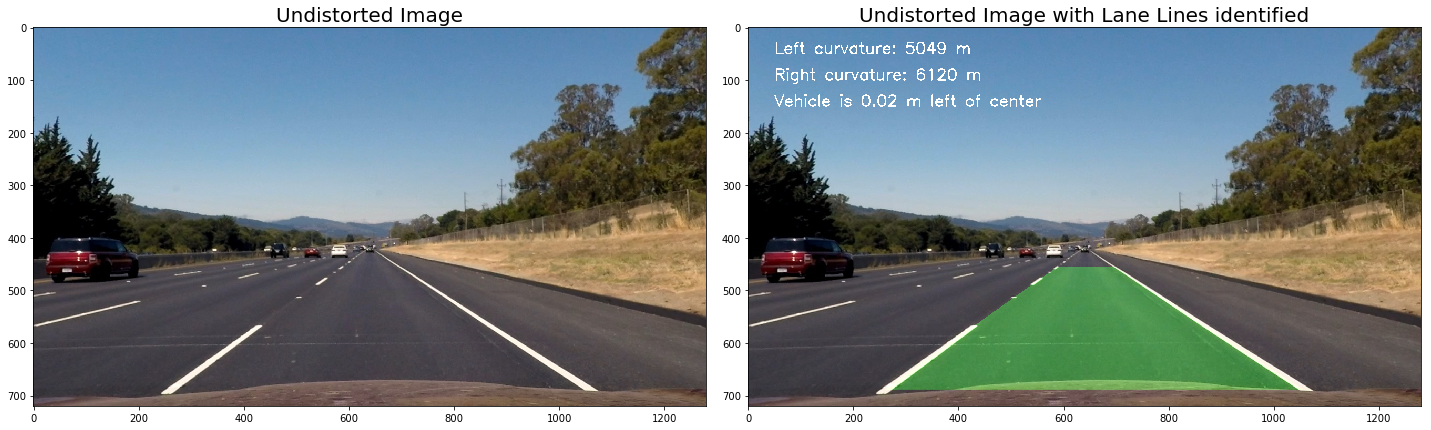

In [20]:
result = draw_lane_lines_on_image(undistorted, binary_warped, left_fitx, right_fitx)
result = draw_info_on_image(result, left_curverad, right_curverad, message)

plot_images_side_by_side(
    undistorted, 'Undistorted Image',
    result, 'Undistorted Image with Lane Lines identified'
)

## Now: Some examples

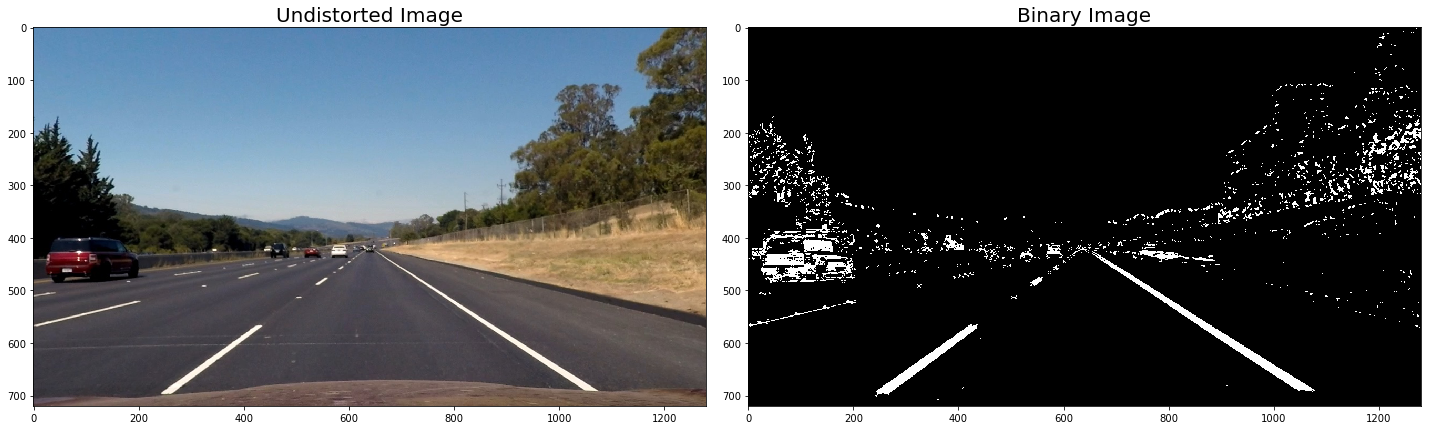

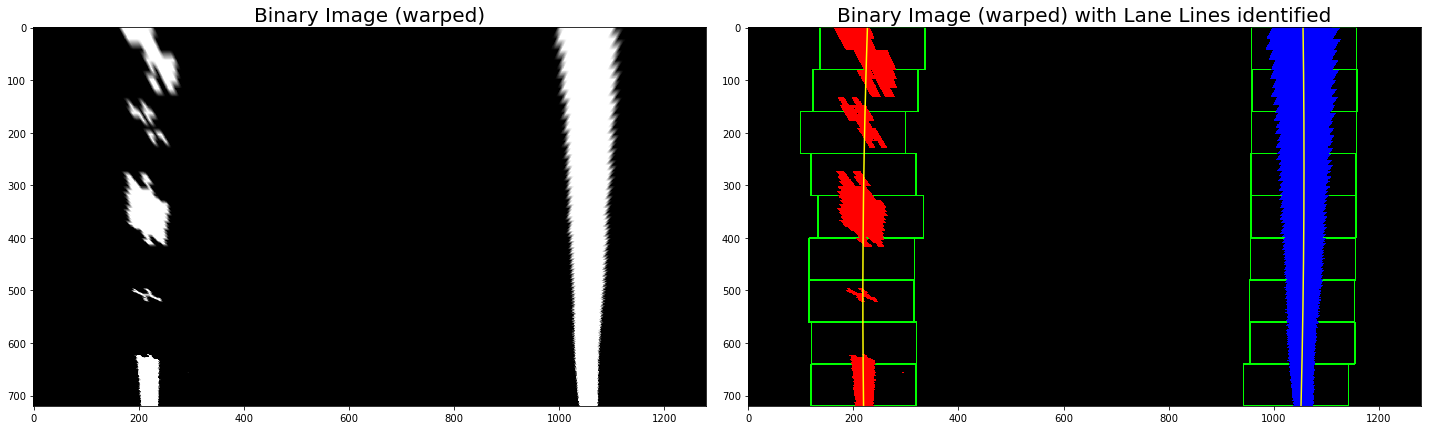

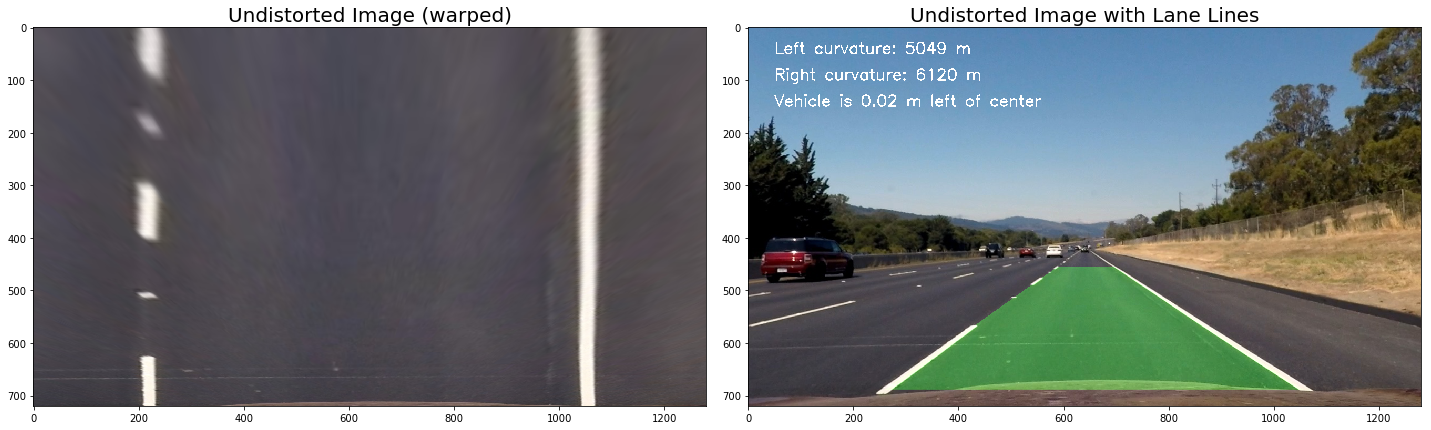

In [21]:
image_index = 0
orig = test_images[image_index][1]
undi = camera.undistort_image(orig)
warp = warper.warp_image(undi)
bina = thresher.combined_thresh(undi)
binawarp = warper.warp_image(bina)

plot_images_side_by_side(
    undi, 'Undistorted Image',
    bina, 'Binary Image'
)

left_fit, right_fit, left_fit_m, right_fit_m, left_fitx, right_fitx = find_and_visualize_lane_lines(binawarp, plt)
left_curverad, right_curverad, message = calculate_lane_curvature_and_vehicle_position(binawarp, left_fit_m, right_fit_m)
result = draw_lane_lines_on_image(undi, binawarp, left_fitx, right_fitx)
result = draw_info_on_image(result, left_curverad, right_curverad, message)

plot_images_side_by_side(
    warp, 'Undistorted Image (warped)',
    result, 'Undistorted Image with Lane Lines'
)

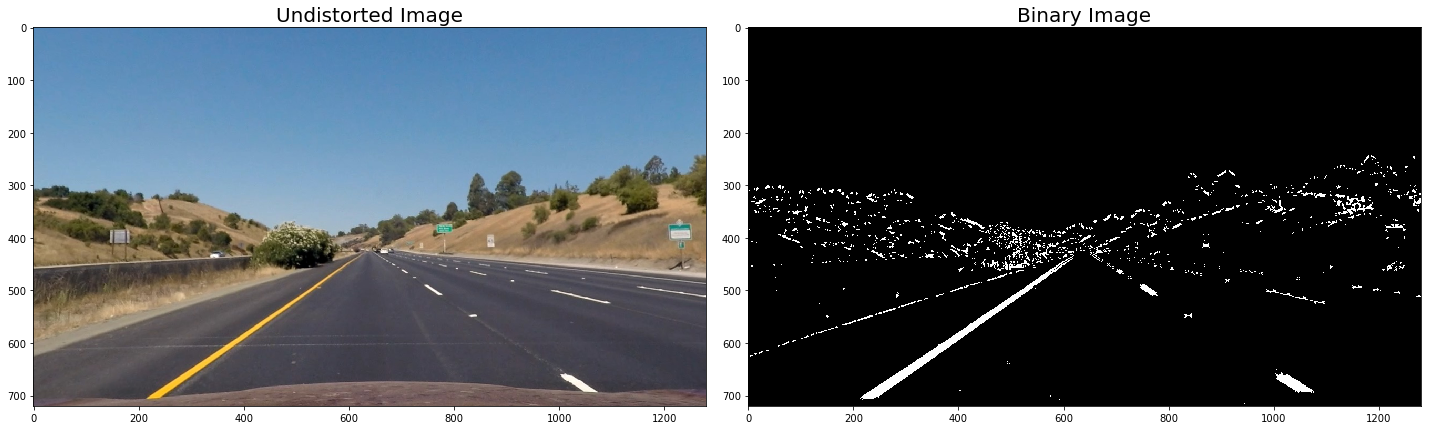

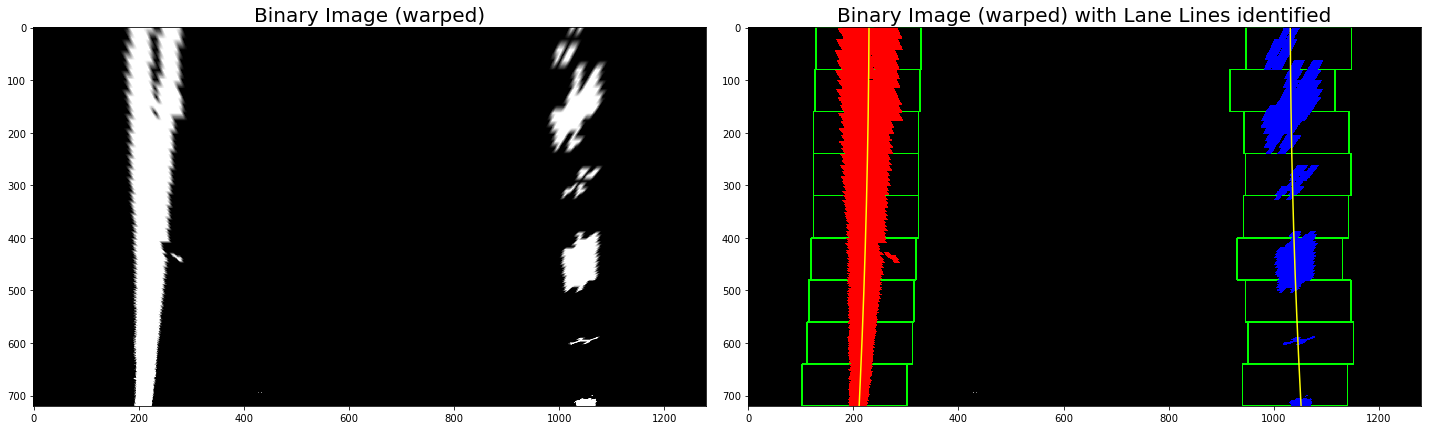

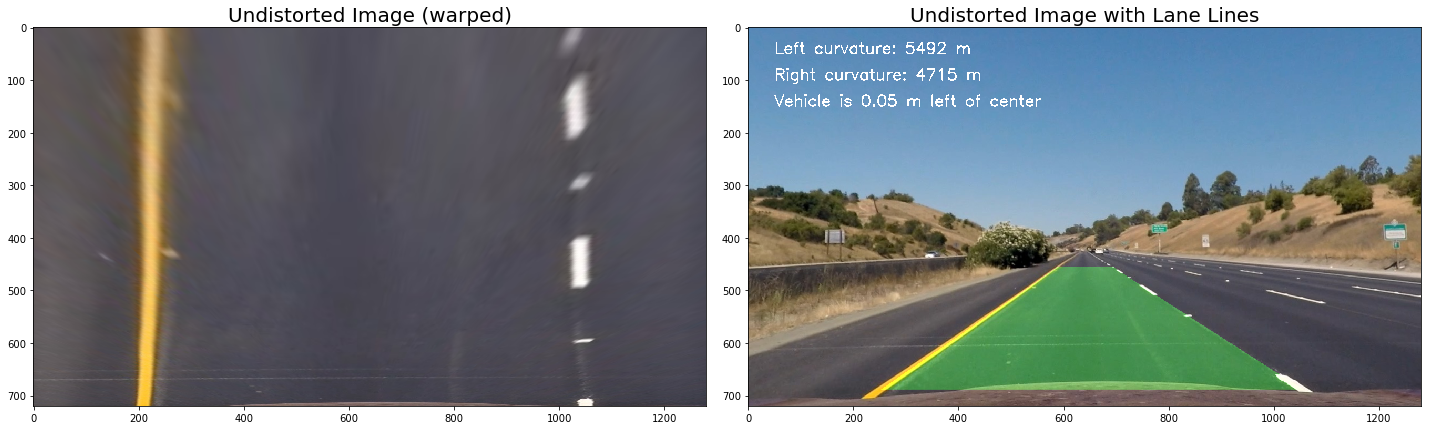

In [22]:
image_index = 1
orig = test_images[image_index][1]
undi = camera.undistort_image(orig)
warp = warper.warp_image(undi)
bina = thresher.combined_thresh(undi)
binawarp = warper.warp_image(bina)

plot_images_side_by_side(
    undi, 'Undistorted Image',
    bina, 'Binary Image'
)

left_fit, right_fit, left_fit_m, right_fit_m, left_fitx, right_fitx = find_and_visualize_lane_lines(binawarp, plt)
left_curverad, right_curverad, message = calculate_lane_curvature_and_vehicle_position(binawarp, left_fit_m, right_fit_m)
result = draw_lane_lines_on_image(undi, binawarp, left_fitx, right_fitx)
result = draw_info_on_image(result, left_curverad, right_curverad, message)

plot_images_side_by_side(
    warp, 'Undistorted Image (warped)',
    result, 'Undistorted Image with Lane Lines'
)

## Video processing

In [23]:
def process_frame(img):
    """
    """
    # Distortion Correction
    undistorted = camera.undistort_image(img)
    # Warp image
    warped = warper.warp_image(undistorted)

    binary = thresher.combined_thresh(undistorted)
    binary_warped = warper.warp_image(binary)

    left_fit, right_fit, left_fit_m, right_fit_m, left_fitx, right_fitx = find_and_visualize_lane_lines(binary_warped, None)
    left_curverad, right_curverad, message = calculate_lane_curvature_and_vehicle_position(binary_warped, left_fit_m, right_fit_m)
    
    result = draw_lane_lines_on_image(undistorted, binary, left_fitx, right_fitx)
    result = draw_info_on_image(result, left_curverad, right_curverad, message)
    
    return result

In [24]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = './output_videos/project_video_output.mp4'

# Load video clip
clip = VideoFileClip('./project_video.mp4')

# Process video clip
white_clip = clip.fl_image(process_frame)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./output_videos/project_video_output.mp4
[MoviePy] Writing video ./output_videos/project_video_output.mp4


100%|█████████▉| 1260/1261 [04:18<00:00,  4.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_videos/project_video_output.mp4 

CPU times: user 5min 11s, sys: 46.5 s, total: 5min 58s
Wall time: 4min 19s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))